In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

sns.set()
pd.set_option('display.max_rows', 16)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
train.shape

(8523, 12)

In [4]:
train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
...,...,...,...,...,...,...,...,...,...,...,...,...
8515,FDH24,20.700,Low Fat,0.021518,Baking Goods,157.5288,OUT018,2009,Medium,Tier 3,Supermarket Type2,1571.2880


In [5]:
#train.describe()

In [6]:
# some columns have missing values
#train.info()

In [7]:
# item weight can be identified as items are unique
#train.isnull().sum()

In [8]:
train.Item_Identifier.unique().shape

(1559,)

In [9]:
# same items available in different stores at different prices
#train[train.Item_Identifier=='FDA15']

In [10]:
#train[train.Item_Identifier=='DRC01']

In [11]:
#train[train.Item_Identifier=='DRA24']

In [12]:
# pandas concat rearranges the columns in alphabetical order. Use train.columns to maintain order
combi = pd.concat([train, test], axis='rows', ignore_index=True)[train.columns]

In [13]:
# fill item weight missing values based on the item identifier
each_item_weight = combi.pivot_table(index=['Item_Identifier'], values=['Item_Weight'], aggfunc=np.nanmean)
for i in each_item_weight.index:
    combi.loc[(combi.Item_Weight.isnull()) & (combi.Item_Identifier==i), 'Item_Weight'] = each_item_weight.Item_Weight[i]

In [14]:
combi.Item_Weight.isnull().sum()

0

In [15]:
combi.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [16]:
combi.Item_Fat_Content = combi.Item_Fat_Content.str.upper()
combi.loc[combi.Item_Fat_Content == 'LF', 'Item_Fat_Content'] = 'LOW FAT'
combi.loc[combi.Item_Fat_Content == 'REG', 'Item_Fat_Content'] = 'REGULAR'

In [17]:
combi

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,LOW FAT,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,REGULAR,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,LOW FAT,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,REGULAR,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,LOW FAT,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,REGULAR,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,REGULAR,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,LOW FAT,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
...,...,...,...,...,...,...,...,...,...,...,...,...
14196,FDF46,7.070,LOW FAT,0.094053,Snack Foods,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN


In [18]:
print(combi.Outlet_Identifier.unique())
print(combi.Outlet_Type.unique())

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [19]:
# splitting the item identifier e.g. FD, DR
combi['Item_Identifier_Type'] = combi.Item_Identifier.str.slice(0,2)
combi['Item_Identifier_Name'] = combi.Item_Identifier.str.slice(2)

In [20]:
combi['Years_of_Operation'] = 2013 - combi['Outlet_Establishment_Year']
combi = combi[['Item_Identifier', 'Item_Identifier_Type', 'Item_Identifier_Name', 'Item_Weight', 'Item_Fat_Content', 
               'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Years_of_Operation', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales']]

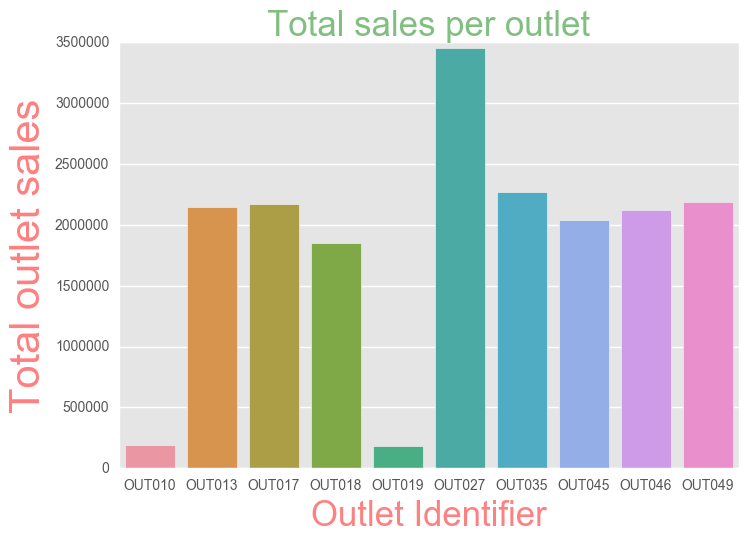

In [21]:
total_outlet_sales = combi.groupby('Outlet_Identifier').agg({'Item_Outlet_Sales':np.nansum})
ax = sns.barplot(x=total_outlet_sales.index, y=total_outlet_sales.Item_Outlet_Sales)
ax.set_title('Total sales per outlet', alpha=0.5, color='green', size=25)
ax.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=25)
ax.set_ylabel('Total outlet sales', alpha=0.5, color='red', size=30)

In [22]:
combi.isnull().sum()

Item_Identifier                 0
Item_Identifier_Type            0
Item_Identifier_Name            0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Years_of_Operation              0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

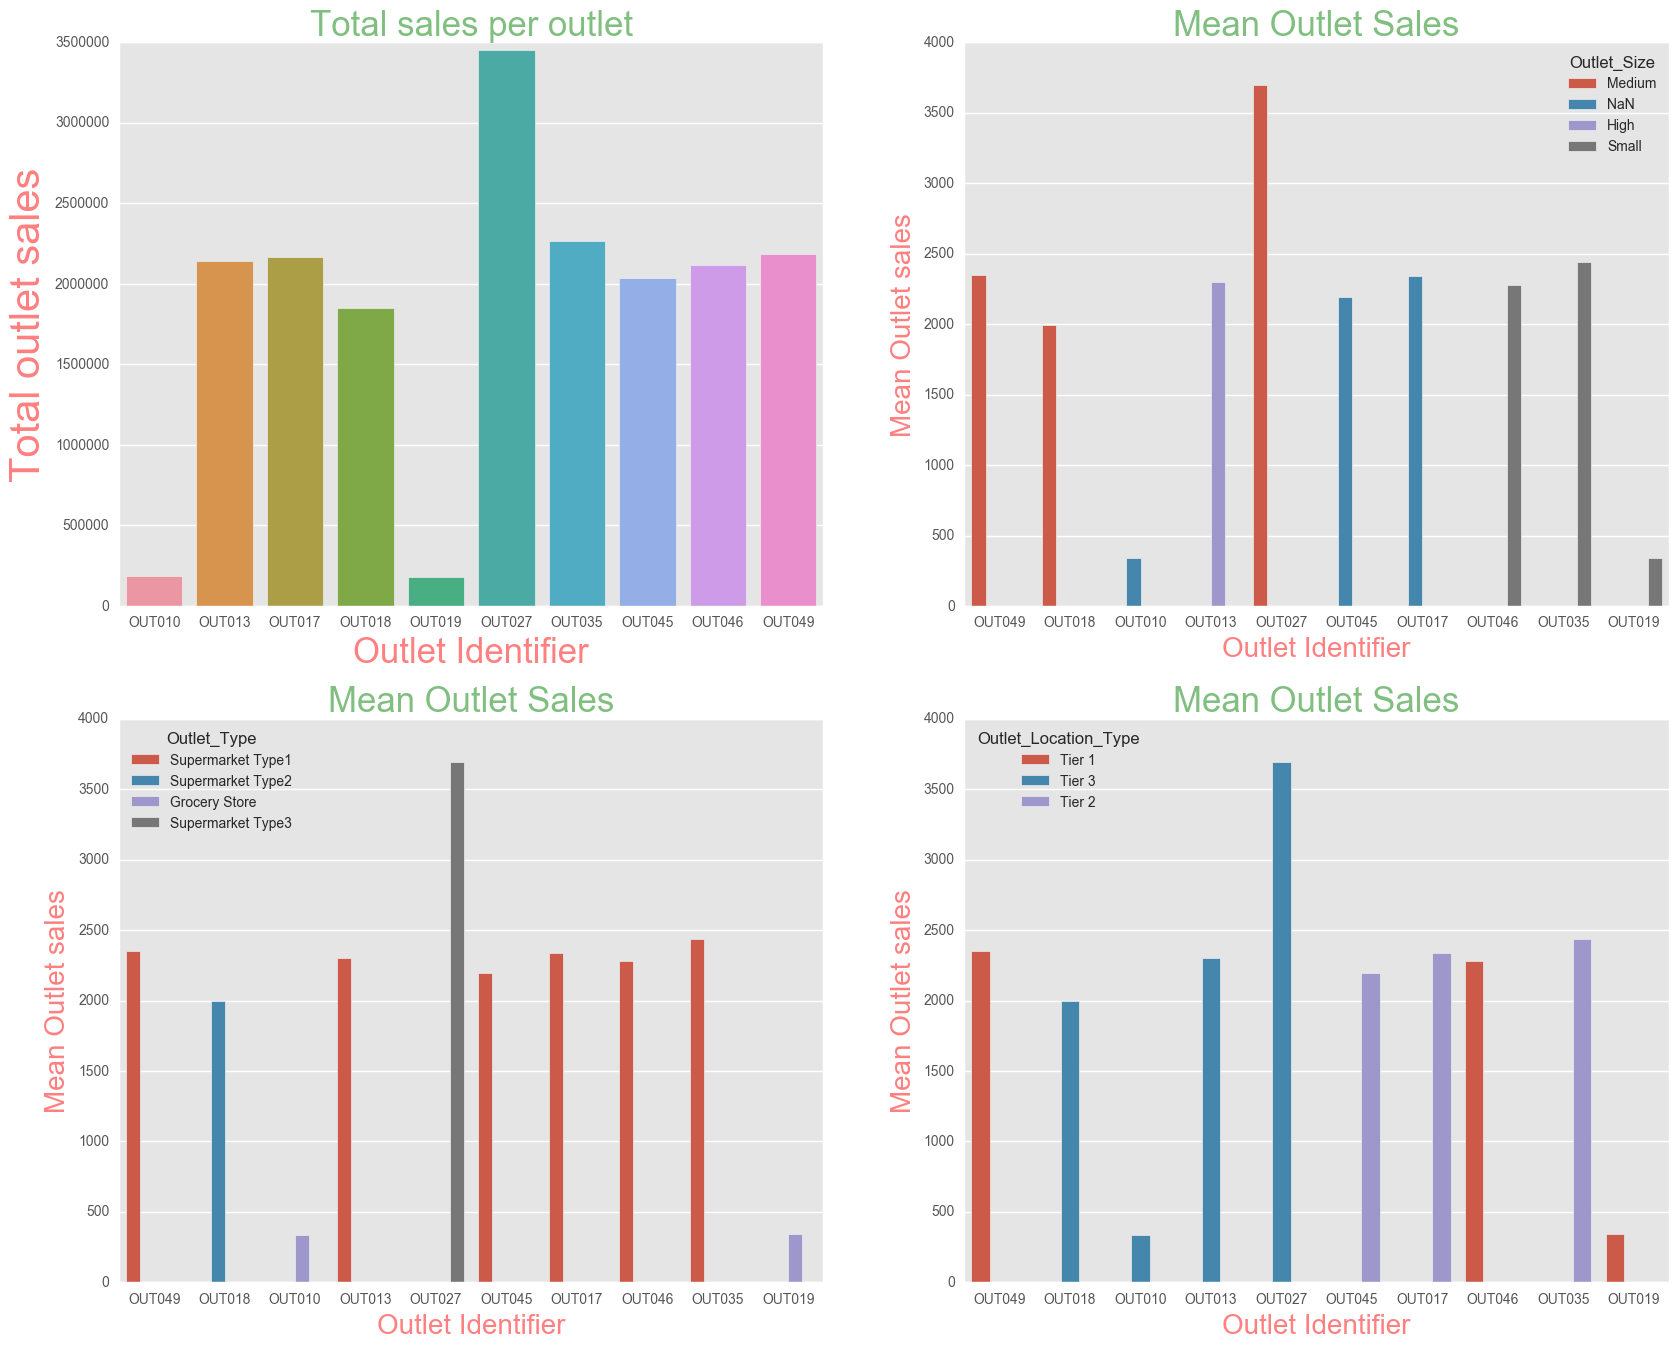

In [23]:
fig, axes = plt.subplots(figsize=(20,16), nrows=2, ncols=2)

ax1 = sns.barplot(x=total_outlet_sales.index, y=total_outlet_sales.Item_Outlet_Sales, ax=axes[0,0])
ax1.set_title('Total sales per outlet', alpha=0.5, color='green', size=25)
ax1.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=25)
ax1.set_ylabel('Total outlet sales', alpha=0.5, color='red', size=30)

ax2 = sns.barplot(x=combi.Outlet_Identifier, y=combi.Item_Outlet_Sales, hue=combi.Outlet_Size.fillna('NaN'), 
                  ci=None, ax=axes[0,1])
ax2.set_title('Mean Outlet Sales', alpha=0.5, color='green', size=25)
ax2.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=20)
ax2.set_ylabel('Mean Outlet sales', alpha=0.5, color='red', size=20)

ax3 = sns.barplot(x=combi.Outlet_Identifier, y=combi.Item_Outlet_Sales, hue=combi.Outlet_Type, ci=None, ax=axes[1,0])
ax3.set_title('Mean Outlet Sales', alpha=0.5, color='green', size=25)
ax3.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=20)
ax3.set_ylabel('Mean Outlet sales', alpha=0.5, color='red', size=20)

ax4 = sns.barplot(x=combi.Outlet_Identifier, y=combi.Item_Outlet_Sales, hue=combi.Outlet_Location_Type, ci=None, ax=axes[1,1])
ax4.set_title('Mean Outlet Sales', alpha=0.5, color='green', size=25)
ax4.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=20)
ax4.set_ylabel('Mean Outlet sales', alpha=0.5, color='red', size=20)

In [24]:
# looking at first 2 plots, we can say that outlet 010 is small
combi.loc[combi.Outlet_Identifier=='OUT010', 'Outlet_Size'] = 'Small'
combi.loc[combi.Outlet_Identifier=='OUT045', 'Outlet_Size'] = 'Medium'
combi.loc[combi.Outlet_Identifier=='OUT017', 'Outlet_Size'] = 'Medium'

In [25]:
# Assuming given products are all the products that a store has. Total visibility of all items in a store should be 100
combi.pivot_table(index=['Outlet_Identifier'], values=['Item_Visibility'], aggfunc=np.sum)

,Item_Visibility
Outlet_Identifier,
OUT010,94.293418
OUT013,93.555174
OUT017,94.342210
OUT018,92.723425
OUT019,94.502641
OUT027,94.075671
OUT035,94.280279
OUT045,94.284513
OUT046,93.285857


In [26]:
# visibility zero is equal to nan
combi.loc[combi.Item_Visibility==0, 'Item_Visibility'] = np.nan

In [27]:
# naive approach. assign equal visibility to each nan item in perticualar store
def per_item_visibility(x):
    return (100-x.sum())/x.isnull().sum()

visibility_per_item = combi.pivot_table(index=['Outlet_Identifier'], values=['Item_Visibility'], 
                                        aggfunc=[np.nansum, per_item_visibility])

for i in visibility_per_item.index:
    combi.loc[(combi.Item_Visibility.isnull()) & (combi.Outlet_Identifier == i), 'Item_Visibility'] = visibility_per_item.per_item_visibility.Item_Visibility[i]

In [28]:
combi.isnull().sum()

Item_Identifier                 0
Item_Identifier_Type            0
Item_Identifier_Name            0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Years_of_Operation              0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [29]:
pd.crosstab(combi.Item_Type, combi.Item_Fat_Content)

Item_Fat_Content,LOW FAT,REGULAR
Item_Type,,
Baking Goods,542,544
Breads,222,194
Breakfast,66,120
Canned,549,535
Dairy,691,445
Frozen Foods,731,695
Fruits and Vegetables,1086,927
Hard Drinks,362,0
Health and Hygiene,858,0


In [30]:
# Hard drinks, health and hygiene, household may not come in low fat category
combi.loc[combi.Item_Type == 'Hard Drinks', 'Item_Fat_Content'] = 'OTHERS'
combi.loc[combi.Item_Type == 'Health and Hygiene', 'Item_Fat_Content'] = 'OTHERS'
combi.loc[combi.Item_Type == 'Household', 'Item_Fat_Content'] = 'OTHERS'

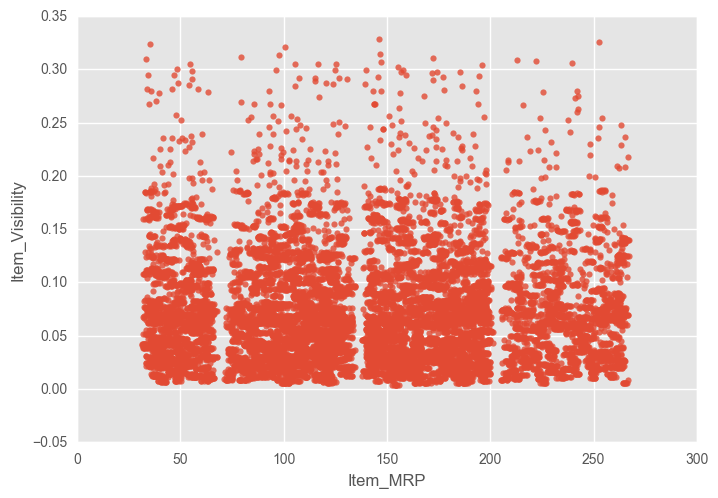

In [31]:
sns.regplot(x=combi.Item_MRP, y=combi.Item_Visibility, fit_reg=False)

C:\Users\Himanshu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


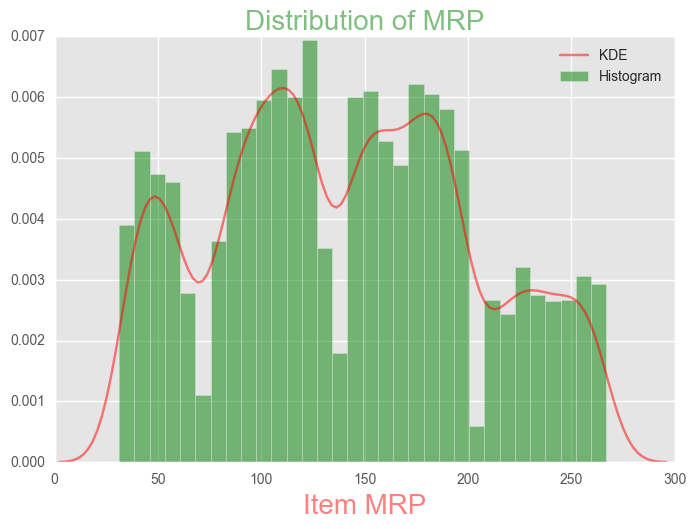

In [32]:
# There seems to be clear distinction in the MRP
# can be binned into 4 bins
ax = sns.distplot(a=combi.Item_MRP, 
             hist_kws={'color':'green', 'alpha':0.5, 'label':'Histogram'}, 
             kde_kws={'color':'red', 'alpha':0.5, 'label':'KDE'})
ax.set_title('Distribution of MRP', alpha=0.5, size=20, color='green')
ax.set_xlabel('Item MRP', alpha=0.5, size=20, color='red')


In [33]:
combi_hotencoded = pd.get_dummies(combi, columns=['Item_Identifier_Type','Item_Fat_Content','Item_Type','Outlet_Identifier',
                               'Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type'])

In [34]:
combi_hotencoded.columns

Index(['Item_Identifier', 'Item_Identifier_Name', 'Item_Weight',
       'Item_Visibility', 'Item_MRP', 'Years_of_Operation',
       'Item_Outlet_Sales', 'Item_Identifier_Type_DR',
       'Item_Identifier_Type_FD', 'Item_Identifier_Type_NC',
       'Item_Fat_Content_LOW FAT', 'Item_Fat_Content_OTHERS',
       'Item_Fat_Content_REGULAR', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Ide

In [36]:
combi_hotencoded = combi_hotencoded[['Item_Identifier', 'Item_Identifier_Name', 'Item_Weight',
       'Item_Visibility', 'Item_MRP','Years_of_Operation',
       'Item_Identifier_Type_DR', 'Item_Identifier_Type_FD',
       'Item_Identifier_Type_NC', 'Item_Fat_Content_LOW FAT',
       'Item_Fat_Content_OTHERS', 'Item_Fat_Content_REGULAR',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Establishment_Year_1985', 'Outlet_Establishment_Year_1987',
       'Outlet_Establishment_Year_1997', 'Outlet_Establishment_Year_1998',
       'Outlet_Establishment_Year_1999', 'Outlet_Establishment_Year_2002',
       'Outlet_Establishment_Year_2004', 'Outlet_Establishment_Year_2007',
       'Outlet_Establishment_Year_2009', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3','Item_Outlet_Sales']]

In [37]:
combi_hotencoded

,Item_Identifier,Item_Identifier_Name,Item_Weight,Item_Visibility,Item_MRP,Years_of_Operation,Item_Identifier_Type_DR,Item_Identifier_Type_FD,Item_Identifier_Type_NC,Item_Fat_Content_LOW FAT,Item_Fat_Content_OTHERS,Item_Fat_Content_REGULAR,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,A15,9.300,0.016047,249.8092,14,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,3735.1380
1,DRC01,C01,5.920,0.019278,48.2692,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,443.4228
2,FDN15,N15,17.500,0.016760,141.6180,14,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,2097.2700
3,FDX07,X07,19.200,0.107671,182.0950,15,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,732.3800
4,NCD19,D19,8.930,0.065764,53.8614,26,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,994.7052
5,FDP36,P36,10.395,0.070646,51.4008,4,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,556.6088
6,FDO10,O10,13.650,0.012741,57.6588,26,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,343.5528
7,FDP10,P10,19.000,0.127470,107.7622,28,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,4022.7636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14196,FDF46,F46,7.070,0.094053,116.0834,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,NaN


In [38]:
train_processed = combi_hotencoded.loc[:len(train)-1, :]
test_processed = combi_hotencoded.loc[len(train):, :]
train_processed = train_processed.reset_index()
test_processed = test_processed.reset_index()
test_processed = test_processed.drop('Item_Outlet_Sales', axis='columns')
print(train_processed.shape)
print(test_processed.shape)

(8523, 59)
(5681, 58)


In [39]:
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

In [48]:
def do_regression_gridcv(estimator, parameters, Xtrain, ytrain, Xtest, ytest, n_jobs=1, n_folds=10):
    if parameters:
        gs = GridSearchCV(estimator=estimator, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
        gs.fit(Xtrain, ytrain)
        estimator = gs.best_estimator_
        print('###########################################')
        print('Best parameter: ', gs.best_params_, '\nBest score: ', gs.best_score_, '\nGrid Score: ', gs.grid_scores_)
    else:
        estimator.fit(Xtrain, ytrain)
    
    training_mse = mean_squared_error(ytrain, estimator.predict(Xtrain))
    test_mse = mean_squared_error(ytest, estimator.predict(Xtest))
    print('###############################################')
    print('Training RMSE : ', np.sqrt(training_mse))
    print('Test RMSE : ', np.sqrt(test_mse))
    print('###############################################')
    return estimator

def plot_feature_importance(estimator, predictors, plot_graph=True):
    feature_imp = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    if plot_graph:
        plt.subplots(figsize=(10,15))
        sns.barplot(x=feature_imp, y=feature_imp.index)
    return feature_imp

In [41]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_processed.iloc[:,3:58], 
                                                train_processed.iloc[:,58], train_size=0.7, random_state=3)

In [58]:
rfReg = RandomForestRegressor(oob_score=True, random_state=20)
parameters = {'n_estimators':[200,500,1000,1500], 'max_features':['auto','sqrt', 0.2, 0.1]}
rfReg = do_regression_gridcv(rfReg, parameters, Xtrain, ytrain, Xtest, ytest, n_jobs=-1, n_folds=5)

###########################################
Best parameter:  {'max_features': 0.2, 'n_estimators': 1000} 
Best score:  0.5548832797308549 
Grid Score:  [mean: 0.54757, std: 0.00868, params: {'max_features': 'auto', 'n_estimators': 200}, mean: 0.54848, std: 0.00848, params: {'max_features': 'auto', 'n_estimators': 500}, mean: 0.54930, std: 0.00896, params: {'max_features': 'auto', 'n_estimators': 1000}, mean: 0.54924, std: 0.00841, params: {'max_features': 'auto', 'n_estimators': 1500}, mean: 0.53612, std: 0.01563, params: {'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.53861, std: 0.01628, params: {'max_features': 'sqrt', 'n_estimators': 500}, mean: 0.53966, std: 0.01638, params: {'max_features': 'sqrt', 'n_estimators': 1000}, mean: 0.53946, std: 0.01592, params: {'max_features': 'sqrt', 'n_estimators': 1500}, mean: 0.55354, std: 0.01437, params: {'max_features': 0.2, 'n_estimators': 200}, mean: 0.55450, std: 0.01402, params: {'max_features': 0.2, 'n_estimators': 500}, mean: 0.5

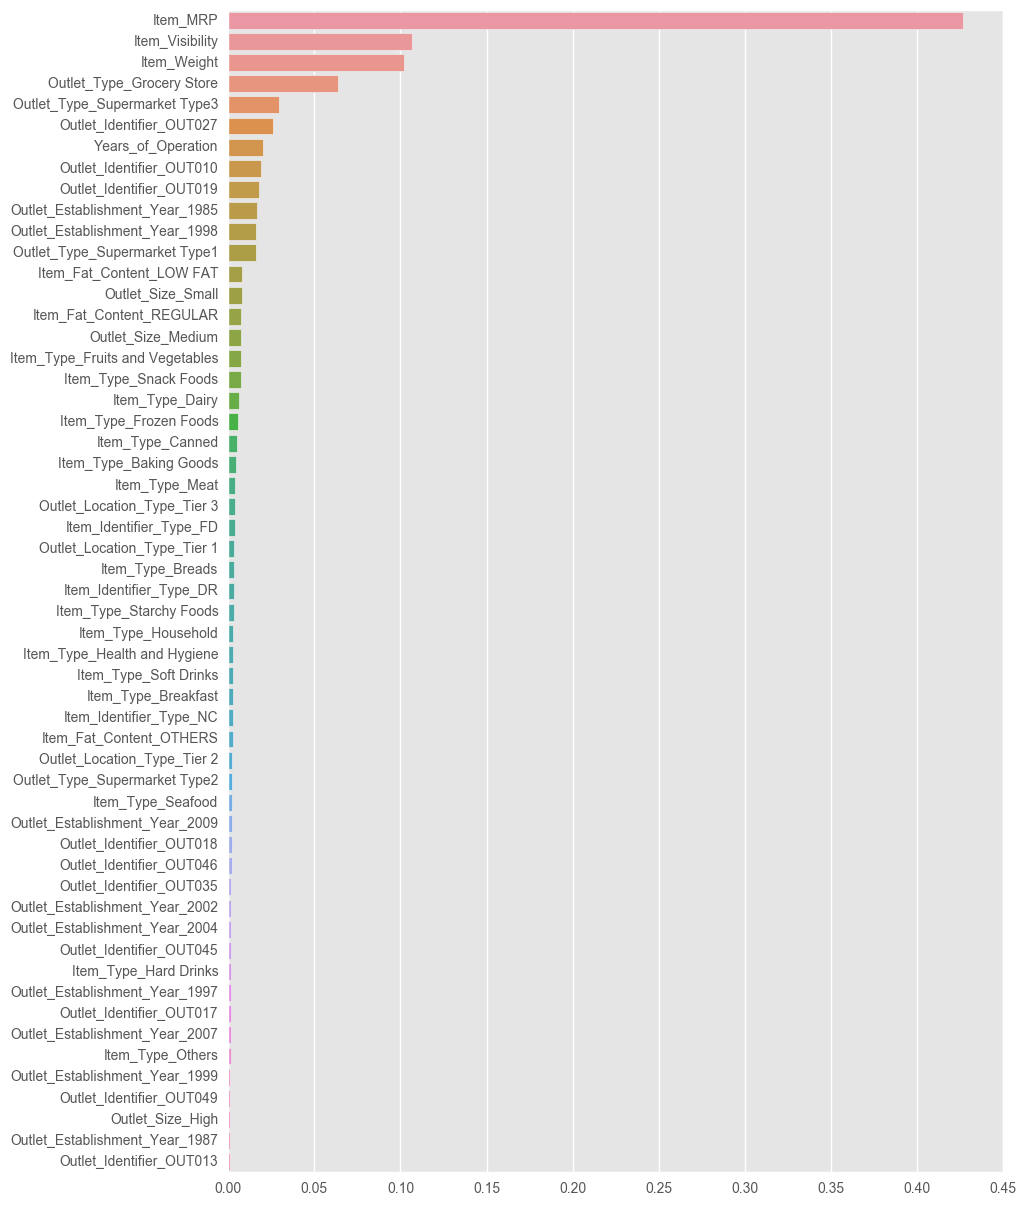

In [61]:
rf_feature_imp = plot_feature_importance(rfReg, Xtrain.columns)
test_pred = rfReg.predict(test_processed.iloc[:,3:58])

In [60]:
rfReg.predict(test_processed.iloc[:,3:58])
subrf = pd.read_csv('SampleSubmission.csv')
subrf.Item_Outlet_Sales = test_pred
subrf.to_csv('subrf_py.csv', index=False)

In [ ]:
gbmReg = GradientBoostingRegressor(random_state=10)
parameters = {'n_estimators':[50,70,100], 'max_depth':[5,8,11,14], 'learning_rate':[0.01,0.05,0.1]}
gbmReg = do_regression_gridcv(gbmReg, parameters, Xtrain, ytrain, Xtest, ytest, n_jobs=-1)

In [ ]:
test_pred_gbm = gbmReg.predict(test_processed.iloc[:,3:58])
sub_gbm = pd.read_csv('SampleSubmission.csv')
sub_gbm.Item_Outlet_Sales = test_pred
sub_gbm.to_csv('sub1_gbm_py.csv', index=False)

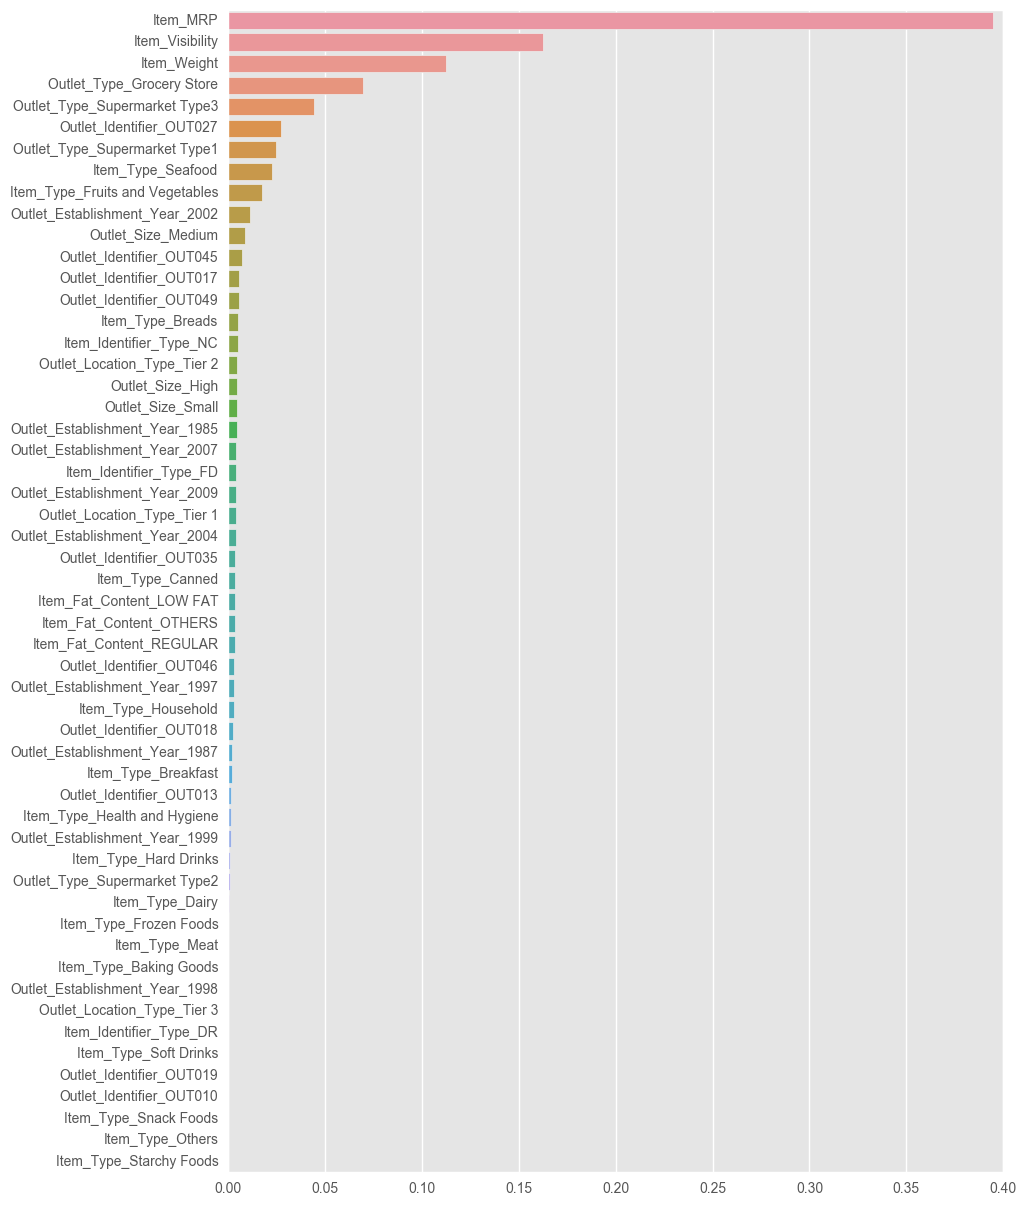

In [911]:
feature_imp = plot_feature_importance(gbmReg, Xtrain.columns)